# Práctica 5: Reducción de la dimensionalidad
Elaborado por: Alejandro Axel Rodríguez Sánchez  
Correo: ahexo@ciencias.unam.mx   
Github: @Ahexo  
Número de Cuenta: 315247697  
Institución: Facultad de Ciencias UNAM  
Asignatura: Lingüística computacional  
Semestre: 2024-2  
Grupo: 7014  

In [96]:
# Para entrenamiento y elaboración de modelos
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models import Word2Vec

# Para operar modelos
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

# Utilidades para manejo de estructuras de datos y miscelanea
import requests
import json
from bs4 import BeautifulSoup as bs
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Un agente sencillo para hacer las consultas web con el servidor de Wikipedia:

In [ ]:
HEADERS = {'User-Agent':'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36'}


In [ ]:
def grab_wikipedia_page_es(article_title:str):
  """
    Hace una petición para obtener el documento html crudo de una página
    de la Wikipedia en español. Si no se encuentra la página, se va a
    lanzar una excepción.

    Parameters
    ----------
    article: str
        Nombre del artículo a consultar.

    Returns
    -------
    str:
        Cadena con el artículo crudo en HTML.
  """

  url = f"https://es.wikipedia.org/api/rest_v1/page/html/{article_title}"
  response = requests.get(url, HEADERS)
  return response.text


def normalize_wiki_page(article:str) -> str:
  """
    Normaliza un artículo de wikipedia crudo, esto es, remueve todas
    las etiquetas HTML y entrega una cadena de texto plano con su
    contenido.

    Parameters
    ----------
    article: str
        Articulo sin normalizar.

    Returns
    -------
    str:
        Artículo normalizado.
  """
  bs_html = bs(article, 'html.parser')
  return bs_html.get_text()

def tokenize_text(text:str) -> list:
    """
    Transforma un texto en una lista segmentada en tokens.

    Parameters
    ----------
    text: str
        Texto a tokenizar.

    Returns
    -------
    list:
        Lista de tokens.
    """
    sentences = [word_tokenize(sentence) for sentence in sent_tokenize(text)]
    return sentences


def get_wiki_sample(title:str) -> list:
    """
    Busca la página de un tópico en Wikipedia y genera un corpus de tokens al
    respecto.

    Parameters
    ----------
    text: str
        Titulo de la página a indexar.

    Returns
    -------
    list:
        Lista de tokens.
    """
    wiki_page = grab_wikipedia_page_es(title)
    normalized_wiki_page = normalize_wiki_page(wiki_page)
    return tokenize_text(normalized_wiki_page)

mexico_wiki_corpus = get_wiki_sample("Mexico")

print(mexico_wiki_corpus)


[['México', '«', 'Mexicano', '»', 'redirige', 'aquí', '.'], ['Para', 'otras', 'acepciones', ',', 'véase', 'Mexicano', '(', 'desambiguación', ')', '.'], ['Para', 'otros', 'usos', 'de', 'este', 'término', ',', 'véase', 'México', '(', 'desambiguación', ')', '.'], ['Estados', 'Unidos', 'MexicanosBanderaEscudo', 'Himno', ':', 'Himno', 'nacional', 'mexicano', '¿Problemas', 'al', 'reproducir', 'este', 'archivo', '?'], ['Capital', '(', 'y', 'ciudad', 'más', 'poblada', ')', 'Ciudad', 'de', 'México', '19°25′10″N', '99°08′44″O\ufeff', '/', '\ufeff19.419444444444', ',', '-99.145555555556', 'Idiomas', 'oficiales', 'español', 'y', '68', 'lenguas', 'indígenas', '[', '1', ']', 'Gentilicio', 'mexicano', ',', '-na', '[', '1', ']', 'mejicano', ',', '-na', '[', '2', ']', 'Forma', 'de', 'gobierno', 'República', 'representativa', ',', 'democrática', ',', 'federal', 'y', 'laica', '•', 'Presidente', 'Andrés', 'Manuel', 'López', 'ObradorÓrgano', 'legislativo', 'Congreso', 'de', 'la', 'Unión', 'Independencia•',

Ahora que tenemos un corpus, podemos entrenar un pequeño modelo de word2vec con el:

In [ ]:
window_size = 6
modelo_word2vec = Word2Vec(mexico_wiki_corpus, vector_size=100, window=window_size, min_count=2, workers=4)

# Lo guardamos y cargamos en memoria
modelo_word2vec.save("word2vec_wikipedia_mex.model")
modelo_word2vec = Word2Vec.load("word2vec_wikipedia_mex.model")

Calculamos el ranking de palabras mas frecuentes

In [ ]:
words = list(modelo_word2vec.wv.index_to_key)
word_freq = Counter(words)
common_words = word_freq.most_common(1000)
common_words = [word for word, _ in common_words]
print(common_words[:25])

['de', ',', '.', 'la', 'el', 'en', 'y', 'del', 'los', 'México', '(', ')', 'que', '[', ']', 'a', '«', '»', 'las', ':', 'se', 'con', 'Consultado', '↑', 'por']


Calculamos vectores correspondientes a las palabras más frecuentes:

In [ ]:
word_vectors = np.array([modelo_word2vec.wv[word] for word in common_words])
print(word_vectors)

[[-0.07284559  0.53667223  0.36981797 ... -0.22131245  0.10455716
   0.14484563]
 [-0.0390329   0.66640085  0.37989745 ... -0.11923494  0.06229818
   0.22329788]
 [-0.03946866  0.5540574   0.29770023 ... -0.16217375  0.05460807
   0.16181327]
 ...
 [ 0.00298304  0.03288427  0.0125803  ... -0.00610246  0.01381965
   0.01614678]
 [ 0.00252882  0.03316091  0.00336536 ... -0.00528107 -0.00153986
   0.00714081]
 [ 0.00434047  0.07119508  0.03100528 ... -0.0173897  -0.00745796
   0.03107741]]


PCA (Principal Component Analysis) es una técnica para reducir la dimensionalidad de un conjunto de vectores, hace uso de operaciones sobre los eigenvalores y la matriz de co-varianza del campo vectorial. Como el resto de técnicas, ya viene implementada en las bibliotecas de sklearn, así que podemos importar y usarla directamente.

In [ ]:
pca = PCA(n_components=2)
word_vectors_pca = pca.fit_transform(word_vectors)

t-SNE es una técnica más de reducción de vectores que se enfoca en incrustar datos de dimensiones mas altas en un espacio de dos o tres dimensiones.

In [ ]:
# Aplicamos t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
word_vectors_tsne = tsne.fit_transform(word_vectors)

SVD divide una matriz en otras auxiliares, y es util para reducir dimensiones también:

In [ ]:
# Aplicamos SVD
svd = TruncatedSVD(n_components=2)
word_vectors_svd = svd.fit_transform(word_vectors)

Graficamos y presentamos los resultados:

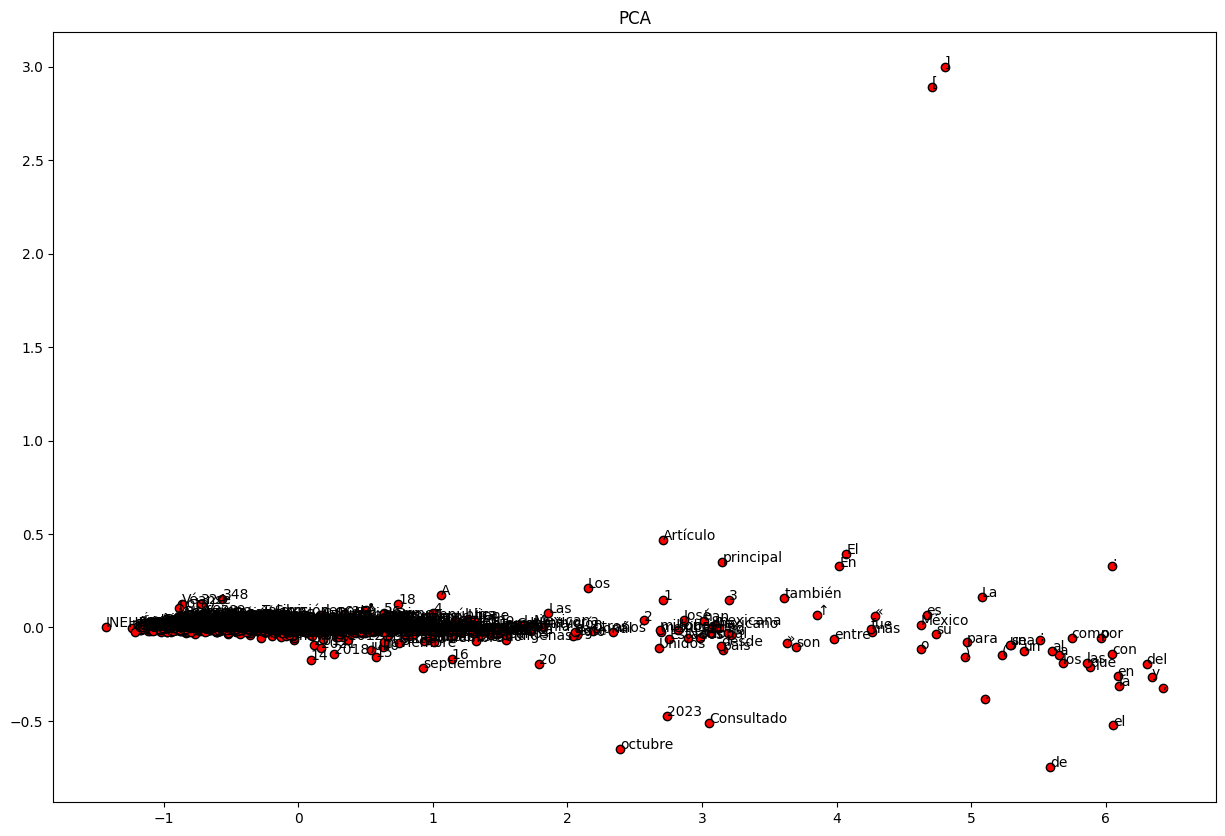

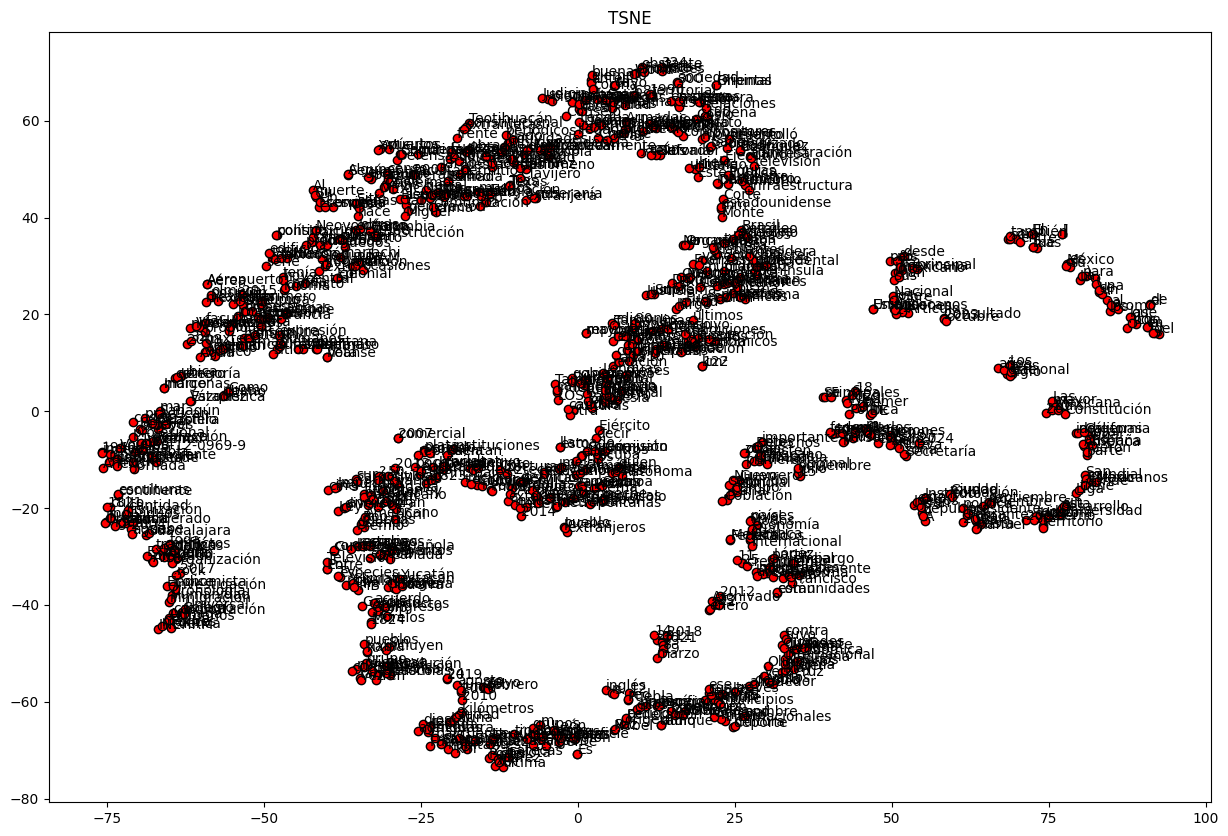

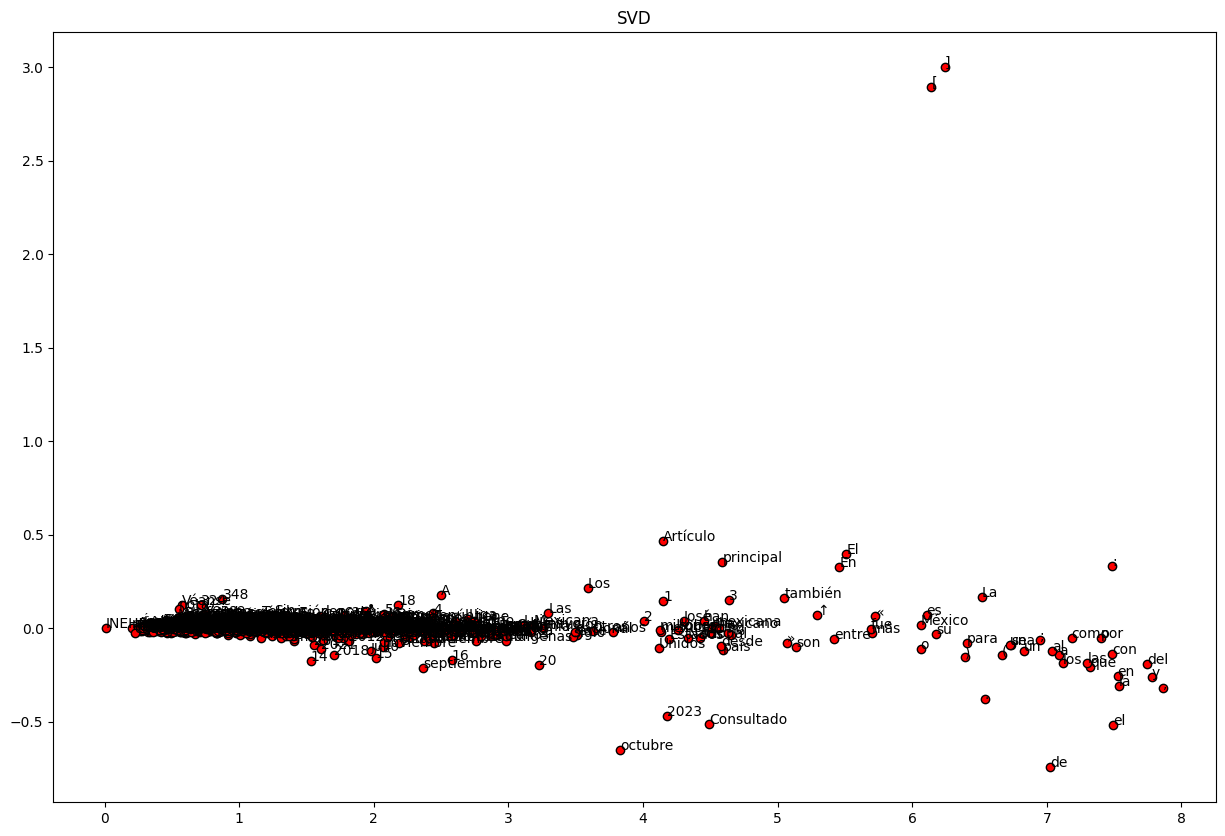

In [ ]:
def plot_vectors(vectors, words, title):
    plt.figure(figsize=(15, 10))
    plt.scatter(vectors[:, 0], vectors[:, 1], edgecolors='k', c='r')
    for i, word in enumerate(words):
        plt.text(vectors[i, 0], vectors[i, 1], word)
    plt.title(title)
    plt.show()

plot_vectors(word_vectors_pca, common_words, "PCA")
plot_vectors(word_vectors_tsne, common_words, "TSNE")
plot_vectors(word_vectors_svd, common_words, "SVD")

## Cuestionamientos

> ¿Se guardan las relaciones semánticas?
No mucho, creo que t-SNE es quien mejor las guarda, PCA y SVD muestran resultados mas parecidos.

> ¿Qué método de reducción de dimensionalidad consideras que es mejor?

Toca ser pragmáticos: PCA es muy eficiente en términos computacionales, pero se sehace de muchas relaciones semánticas. t-SNE se desempeña mejor en este último aspecto, pero es computacionalmente mas costosa, pues se divide en mas matrices. SVD es poco mas versatil, pero sufre de las mismas deficiencias de PCA, pues se deja las relaciones no-lineales detrás.

Dependerá del problema que se quiere atacar y los recursos de cómputo con los que se cuenta.